In [1]:
!pip3 install sklearn progress iterative-stratification pandas pyss3
from sklearn.model_selection import train_test_split

In [2]:
# !git clone https://github.com/sergioburdisso/pyss3.git

In [3]:
from pyss3 import SS3
from pyss3.util import Dataset, membership_matrix, Evaluation, span
from pyss3.server import Live_Test
from pyss3.__init__ import vsum, vmax, vdiv
from functools import reduce
from sklearn.metrics import accuracy_score, hamming_loss, f1_score

from google.colab import drive
from sys import path
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

In [4]:
drive.mount('/content/drive', force_remount=True)
path_root = '/content/drive/My Drive/NLP Lab'
path.append(path_root)
data_root = '/data'
# single_label_dir = '/SB1_Train-entity'

Mounted at /content/drive


In [5]:
multi_label_dir_test = '/Muneeb-Entity-Testing'
multi_label_dir_train = '/SB1_Train_Multilabel'
 


**LOADING DATA**

In [6]:
multi_text_train, multi_labels_train = Dataset.load_from_files_multilabel(path_root + data_root + multi_label_dir_train + '/entity-text.txt', path_root + data_root + multi_label_dir_train + '/entity-labels.txt', sep_label=';')
# multi_text_test, multi_labels_test = Dataset.load_from_files_multilabel(path_root + data_root + multi_label_dir_test + '/entity-text.txt', path_root + data_root + multi_label_dir_test + '/entity-labels.txt', sep_label=';')

100%|██████████| 3748/3748 [00:00<00:00, 555937.74it/s]


In [22]:
# multi_text_train, multi_text_test, multi_labels_train, multi_labels_test = train_test_split(multi_text_train, multi_labels_train, test_size=0.3)

**DATA FILTERING AND DATASET EXPLORATION**



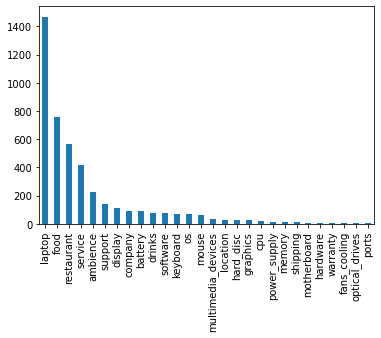

In [7]:
# CLASSES DISTRUBUTION

pd.Series([y for yy in multi_labels_train for y in yy]).value_counts().plot(kind ='bar')

In [8]:
pd.Series([y for yy in multi_labels_train for y in yy]).value_counts()

laptop                1468
food                   757
restaurant             564
service                419
ambience               226
support                144
display                114
company                 90
battery                 89
drinks                  79
software                75
keyboard                70
os                      67
mouse                   65
multimedia_devices      37
location                28
hard_disc               25
graphics                25
cpu                     21
power_supply            16
memory                  16
shipping                12
motherboard              7
hardware                 6
warranty                 6
fans_cooling             5
optical_drives           5
ports                    5
dtype: int64

In [9]:
print("Number of classes: ", len(set([y for yy in multi_labels_train for y in yy])))

Number of classes:  28


In [10]:
def remove_classes(text, labels, restricted_labels):
  indexes = []
  for c,values in enumerate(labels):
    allowed_labels = [value for value in values if value not in restricted_labels]
    if len(allowed_labels):
      labels[c] = allowed_labels
    else:
      indexes.append(c)

  for index in sorted(indexes, reverse=True):
    del text[index]
    del labels[index]  

In [11]:
def top_classes_overlap(labels):
  all_classes = {}
  classes = list(set([y for yy in labels for y in yy]))
  for main_class in classes:
    Frequency = {}
    for label_list in labels:
      if main_class in label_list:
        keys = list(itertools.product([main_class], label_list))
        for key in keys:
          if key in Frequency:
            Frequency[key] = Frequency[key] + 1
          else:
            Frequency[key] = 1
    Frequency = {k: v for k, v in sorted(Frequency.items(), key=lambda item: item[1],reverse=True)}
    all_classes[main_class] = Frequency
  return all_classes

In [12]:
def false_negative_distribution(clf,category, x_val, y_val, def_cat):
  FN = {}
  Frequency = {}
  count = 0
  for c,labels in enumerate(y_val):
    if category in labels:
      predicted = clf.classify_multilabel(x_val[c], def_cat= def_cat)
      if category not in predicted:
        count += 1
        FN[x_val[c]] = predicted
        for label in predicted:
          if label in Frequency:
            Frequency[label] = Frequency[label] + 1
          else:
            Frequency[label] = 1
  
  print("# False Negative: ", count)
  Frequency = {k: v for k, v in sorted(Frequency.items(), key=lambda item: item[1],reverse=True)}
  plt.bar(Frequency.keys(), Frequency.values(), width=1, color='g')
  plt.xticks(rotation=90)
  plt.show()
  return [Frequency, FN]

**Train Test Split**


In [16]:
X_train, X_val, y_train, y_val = train_test_split(multi_text_train, multi_labels_train, test_size=0.2)
# X_train, X_val, y_train, y_val = train_test_split(X_fin, multi_labels_train, test_size=0.2)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1111)

**DEFAULT SS3**

Classification: 100%|██████████| 750/750 [00:00<00:00, 11342.70it/s]



                    precision    recall  f1-score   support

           support       0.23      0.89      0.36        35
              food       0.35      0.98      0.51       154
           battery       0.12      0.62      0.21        13
            laptop       0.54      0.96      0.69       291
          ambience       0.15      0.84      0.26        49
           service       0.22      0.84      0.35        80
        restaurant       0.27      0.91      0.41       116
             mouse       0.21      0.67      0.32         9
          keyboard       0.12      0.67      0.20         9
    optical_drives       0.00      0.00      0.00         0
          shipping       0.05      1.00      0.10         1
           company       0.13      0.86      0.23        21
             ports       0.02      1.00      0.04         2
          software       0.13      0.75      0.22        16
           display       0.26      0.55      0.35        22
            memory       0.45      0.8

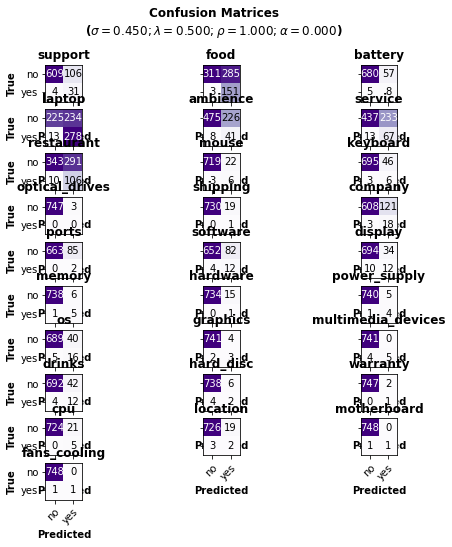

0.36064660666554405

In [17]:
clf = SS3() 
# clf.summary_op_ngrams = dummy_summary_ops
Evaluation.clear_cache(clf)
clf.train(X_train, y_train)
Evaluation.test(clf, X_val, y_val,metric="f1-score", plot=True, cache=False)


**N-GRAM SS3**

Classification: 100%|██████████| 750/750 [00:01<00:00, 566.69it/s]



                    precision    recall  f1-score   support

           support       0.29      0.77      0.42        35
              food       0.42      0.97      0.59       154
           battery       0.29      0.77      0.43        13
            laptop       0.53      0.96      0.68       291
          ambience       0.20      0.71      0.31        49
           service       0.30      0.80      0.44        80
        restaurant       0.32      0.83      0.46       116
             mouse       0.29      0.44      0.35         9
          keyboard       0.24      0.67      0.35         9
    optical_drives       0.00      0.00      0.00         0
          shipping       0.07      1.00      0.12         1
           company       0.19      0.67      0.29        21
             ports       0.02      0.50      0.04         2
          software       0.20      0.62      0.31        16
           display       0.36      0.41      0.38        22
            memory       0.55      1.0

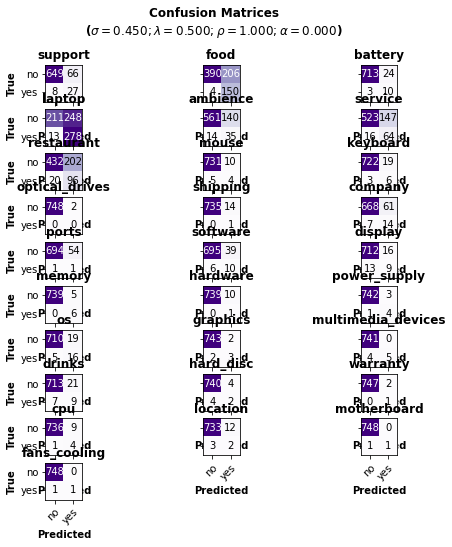

0.4219062803858652

In [18]:
clf = SS3() 
# clf.summary_op_ngrams = dummy_summary_ops
Evaluation.clear_cache(clf)
clf.train(X_train, y_train, n_grams=5)
Evaluation.test(clf, X_val, y_val,metric="f1-score", plot=True, cache=False)

**DIFFERENT OPERATORS**

Classification: 100%|██████████| 750/750 [00:01<00:00, 515.85it/s]



                    precision    recall  f1-score   support

           support       0.19      0.54      0.28        35
              food       0.46      0.90      0.61       154
           battery       0.14      0.77      0.24        13
            laptop       0.55      0.86      0.67       291
          ambience       0.19      0.71      0.30        49
           service       0.35      0.76      0.48        80
        restaurant       0.33      0.71      0.45       116
             mouse       0.20      0.44      0.28         9
          keyboard       0.14      0.89      0.24         9
    optical_drives       0.00      0.00      0.00         0
          shipping       0.04      1.00      0.07         1
           company       0.15      0.86      0.26        21
             ports       0.02      1.00      0.04         2
          software       0.15      0.75      0.25        16
           display       0.28      0.50      0.35        22
            memory       0.35      1.0

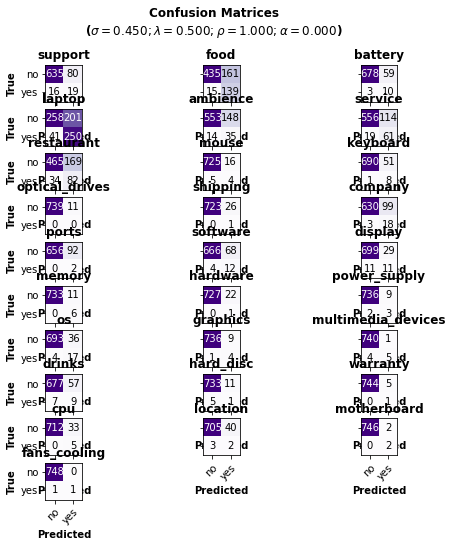

0.3330919689813558

In [19]:
def dummy_summary_ops_max(cvs):
  return list(np.max(np.array(cvs), axis=0))
clf = SS3()
Evaluation.clear_cache(clf)
clf.summary_op_ngrams = dummy_summary_ops_max
clf.summary_op_sentences = dummy_summary_ops_max
clf.train(X_train, y_train, n_grams=5)
Evaluation.test(clf, X_val, y_val,metric="f1-score", plot=True, cache=False)

Classification: 100%|██████████| 750/750 [00:01<00:00, 514.46it/s]



                    precision    recall  f1-score   support

           support       0.29      0.77      0.42        35
              food       0.42      0.97      0.59       154
           battery       0.29      0.77      0.43        13
            laptop       0.53      0.96      0.68       291
          ambience       0.20      0.71      0.31        49
           service       0.30      0.80      0.44        80
        restaurant       0.33      0.83      0.47       116
             mouse       0.29      0.44      0.35         9
          keyboard       0.24      0.67      0.35         9
    optical_drives       0.00      0.00      0.00         0
          shipping       0.07      1.00      0.12         1
           company       0.18      0.67      0.29        21
             ports       0.02      0.50      0.03         2
          software       0.20      0.62      0.31        16
           display       0.36      0.41      0.38        22
            memory       0.55      1.0

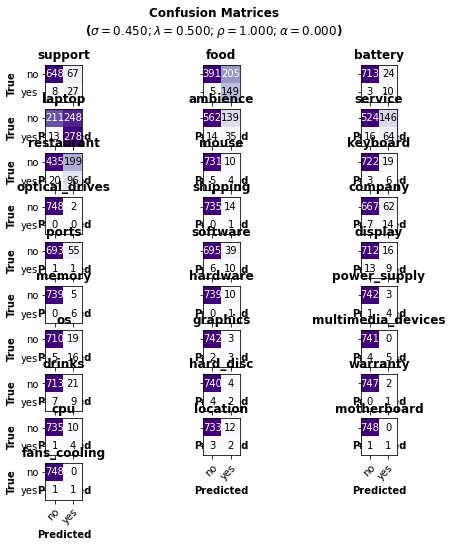

0.4190442343409807

In [20]:
def dummy_summary_ops_avg(cvs):
  return list(np.average(np.array(cvs), axis=0))
clf = SS3()
Evaluation.clear_cache(clf)
clf.summary_op_ngrams = dummy_summary_ops_avg
clf.summary_op_sentences = dummy_summary_ops_avg
clf.train(X_train, y_train, n_grams=5)
Evaluation.test(clf, X_val, y_val,metric="f1-score", plot=True, cache=False)

**EXPERIMENT**

In [21]:
restricted_labels = ['hardware', 'motherboard', 'warranty', 'ports', 'optical_drives', 'fans_cooling', 'memory','shipping','graphics']
remove_classes(multi_text_train, multi_labels_train, restricted_labels)

In [22]:
X_train, X_val, y_train, y_val = train_test_split(multi_text_train, multi_labels_train, test_size=0.2)

Classification: 100%|██████████| 743/743 [00:00<00:00, 767.09it/s]



                    precision    recall  f1-score   support

            laptop       0.53      0.99      0.69       305
           service       0.46      0.77      0.58        88
        restaurant       0.34      0.85      0.48       110
          ambience       0.38      0.67      0.49        45
          software       0.35      0.35      0.35        20
                os       0.43      0.62      0.51        16
           company       0.15      0.79      0.25        14
           battery       0.25      0.77      0.38        13
             mouse       0.40      0.55      0.46        11
              food       0.58      0.88      0.70       148
multimedia_devices       0.80      0.44      0.57         9
           support       0.22      0.82      0.34        28
            drinks       0.48      0.70      0.57        20
      power_supply       1.00      0.33      0.50         3
           display       0.42      0.50      0.46        22
          location       0.13      0.6

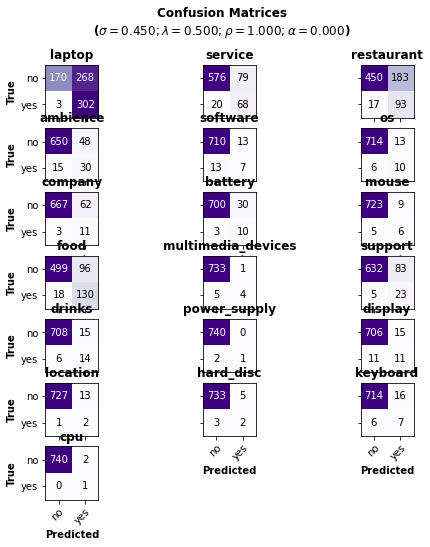

0.4619671567477465

In [23]:
clf = SS3() 
# clf.summary_op_ngrams = dummy_summary_ops
Evaluation.clear_cache(clf)
clf.train(X_train, y_train, n_grams=5)
Evaluation.test(clf, X_val, y_val,metric="f1-score", plot=True, cache=False)

**GRID SEARCH**

In [ ]:
s_vals=span(0, 1, 11) 
l_vals=span(0, 1, 11)
p_vals=span(0,1,11)
a_vals=0.5

In [ ]:
best_s, best_l, best_p, best_a = Evaluation.grid_search(
    clf 
    ,x_val 
    ,y_val
    # ,k_fold=3
    ,s=s_vals
    ,l=l_vals
    ,p=p_vals
    ,a=a_vals
    ,cache=False
    ,metric ="f1-score"
    ,n_grams = 5)

In [ ]:
print(best_s, best_l, best_p, best_a)

clf.set_hyperparameters(s=best_s, l=best_l, p=best_p, a=best_a)
Evaluation.test(clf, x_val, y_val, metric="f1-score", plot=True,cache=False)


In [ ]:
## own implementation of grid search, check util.py for code

from util import grid_search

labels = list(set([y for yy in multi_labels_train for y in yy]))
(best_s,best_l,best_p,best_a) = grid_search(clf,X_val,y_val, labels, metric = f1_score,s = s_vals,l = l_vals, p = p_vals, a= a_vals, **{"average":"macro","zero_division" : 0})


In [ ]:
# clf.set_hyperparameters(s=best_s, l=best_l, p=best_p, a=best_a)
# Evaluation.test(clf, x_val, y_val, metric="f1-score", plot=True, def_cat="unknown", cache=False)

# **LIVE TEST**

In [ ]:
#  Live_Test.run(clf, x_val, y_val)